In [130]:
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict

In [2]:
mp = pd.read_csv(Path.cwd().parent / 'summaries' / 'marginal_prices_summary_flex.csv', index_col=0, parse_dates=True, header=[0,1])
sc = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_summary_flex.csv', index_col=[0,1], parse_dates=True)

C:\Users\lukas\AppData\Local\Temp\ipykernel_36140\619580916.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sc = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_summary_flex.csv', index_col=[0,1], parse_dates=True)


In [3]:
sc.index.get_level_values(1).unique()

Index(['wholesale', 'congestion_rent', 'cfd_payments', 'roc_payments',
       'offer_cost', 'bid_cost', 'balancing_volume'],
      dtype='object')

In [142]:
lw = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'load_weights.csv', index_col=0)
lw.index = lw.index.astype(str)

In [5]:
regions = gpd.read_file(Path.cwd().parent / 'data' / 'regions_onshore_s.geojson')

In [ ]:
start, end = '2022-01-01', '2023-06-30'

date_range = pd.date_range(start, end).strftime('%Y-%m-%d')

In [33]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv', index_col=0)
foss = bmus.loc[bmus.loc[:, 'carrier'] == 'fossil']

foss

,carrier,bus,lon,lat
NationalGridBmUnit,,,,
BRGDG-1,fossil,6038,-0.508006,53.540993
AG-NHAV02,fossil,5913,-3.781,55.803
ABERU-1,fossil,6049,-1.270137,53.090486
BRGG-1,fossil,6042,-0.32959,53.442264
BRIDU-1,fossil,6037,-0.203475,54.086555
...,...,...,...,...
GRAI-6,fossil,4972,0.703125,51.47454
GRAI-7,fossil,4972,0.703125,51.47454
GRAI-8,fossil,4972,0.703125,51.47454


In [ ]:
loads = []

for day in date_range:

    try:
        n = pypsa.Network(Path.cwd().parent / 'results' / day / 'network_flex_s_national.nc')
        l = n.loads.query('carrier == "electricity"').index
        loads.append(n.loads_t.p_set[l])
    except FileNotFoundError:
        continue

loads = pd.concat(loads)

In [32]:
from tqdm import tqdm

pns = []

for day in tqdm(date_range):

    try:
        pns.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / day / 'physical_notifications.csv',
                index_col=0
                )
            )
    except FileNotFoundError:
        continue

pns = pd.concat(pns)

  0%|          | 0/546 [00:00<?, ?it/s]

100%|██████████| 546/546 [00:28<00:00, 18.86it/s]


In [44]:
from tqdm import tqdm

dap = []

for day in tqdm(date_range):

    try:
        dap.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / day / 'day_ahead_prices.csv',
                index_col=0
                )
            )
    except FileNotFoundError:
        continue

dap = pd.concat(dap).iloc[:,0]

100%|██████████| 546/546 [00:00<00:00, 682.30it/s]


In [45]:
gas_gen = pns.loc[:, pns.columns.intersection(foss.index)].sum(axis=1)

In [48]:
(dap <= 0).sum() / len(dap)

0.008547660841028771

In [11]:
lw

,load_weight
name,
8838,0.002569
8013,0.000261
8520,0.000241
8649,0.004041
4950,0.003187
...,...
7458,0.001419
8283,0.005545
8094,0.004038


In [15]:
idx = pd.IndexSlice

zmp = mp.loc[:, idx['zonal',:]]
nmp = mp.loc[:, idx['national',:]]

In [55]:
(nmp.iloc[:,0] == 0).sum()


93

In [13]:
n_values = zmp.apply(lambda x: x.nunique(), axis=1)

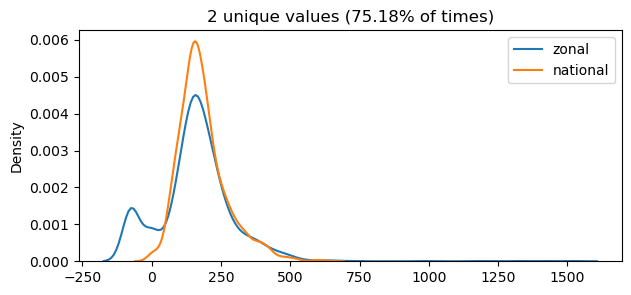

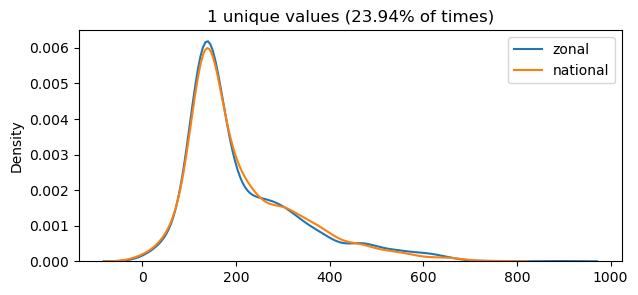

In [25]:
import seaborn as sns

for i in n_values.unique()[:2]:

    ssz = zmp.loc[n_values.loc[n_values == i].index]
    ssn = nmp.loc[n_values.loc[n_values == i].index]

    fig, ax = plt.subplots(figsize=(7, 3))

    sns.kdeplot(np.random.choice(ssz.values.flatten(), 2000), ax=ax, label='zonal')
    sns.kdeplot(np.random.choice(ssn.values.flatten(), 2000), ax=ax, label='national')

    share_of_times = np.around(100 * (ssn.shape[0] / len(nmp.index)), 2)

    ax.set_title(f'{i} unique values ({share_of_times}% of times)')

    ax.legend()
    plt.show()



In [62]:
(zmp < 0).any(axis=1).sum() / len(zmp)

0.38507589327802394

In [71]:
nmp.columns = nmp.columns.get_level_values(1)

In [73]:
zmp.columns = zmp.columns.get_level_values(1)

In [83]:
def classify_period(nat, lmp):

    nat = nat.copy()
    lmp = lmp.copy()

    nat_negative_mask = nat.loc[nat.iloc[:,0] <= 0].index

    nat_negative_prices = {
        'national': nat.loc[nat_negative_mask],
        'zonal': lmp.loc[nat_negative_mask],
    }

    lmp.drop(nat_negative_mask, inplace=True)
    nat.drop(nat_negative_mask, inplace=True)

    all_positive_mask = lmp.loc[(lmp > 0).all(axis=1)].index

    all_positive_prices = {
        'national': nat.loc[all_positive_mask],
        'zonal': lmp.loc[all_positive_mask],
    }

    lmp.drop(all_positive_mask, inplace=True)
    nat.drop(all_positive_mask, inplace=True)

    mixed_prices = {
        'national': nat,
        'zonal': lmp,
    }

    return nat_negative_prices, all_positive_prices, mixed_prices


neg, pos, mixed = classify_period(nmp, zmp)

In [93]:
neg['national'].index.difference(loads.index).strftime('%Y-%m-%d').unique()

Index(['2022-02-17', '2022-02-20', '2022-12-18', '2022-12-25', '2022-12-26',
       '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30', '2023-01-01',
       '2023-01-07', '2023-01-08', '2023-01-10', '2023-01-11', '2023-01-13',
       '2023-01-15', '2023-03-13'],
      dtype='object', name='snapshot')

In [100]:
len(zmp.index)

21214

In [99]:
len(loads.reindex(zmp.index).interpolate(method='linear'))

21214

In [104]:
loads.reindex(zmp.index).interpolate(method='linear').loc[neg['national'].index]

Load,GB electricity
snapshot,
2022-01-03 05:00:00,23855.233333
2022-02-17 03:00:00,25176.950000
2022-02-17 03:30:00,24985.137500
2022-02-17 04:00:00,24793.325000
2022-02-17 04:30:00,25118.425000
...,...
2023-01-15 06:00:00,22448.358333
2023-01-15 06:30:00,24401.358333
2023-03-13 05:00:00,22381.608333


In [116]:
sc.index.get_level_values(1).unique()

Index(['wholesale', 'congestion_rent', 'cfd_payments', 'roc_payments',
       'offer_cost', 'bid_cost', 'balancing_volume'],
      dtype='object')

In [219]:


def bars_to_ax(ax, lmp, loads, weights, costs, index_groups):

    distributed_price = costs.sum().drop('wholesale') / loads.sum().sum() / 2 * 1e6

    total_load = loads.sum().sum()

    bar_kwargs = {
        'alpha': 0.8,
    }
    # Create distinct colors for each cost component.

    for j, group in enumerate(index_groups):

        cumulative_positive = 0
        cumulative_negative = 0

        for i, (cat, value) in enumerate(distributed_price.items()):

            if value >= 0:
                ax.bar(j-0.25, value, width=0.5, bottom=cumulative_positive,
                    color=color_dict[cat], align='edge', label=f"cost: {cat}", **bar_kwargs)
                ax.plot(
                    [j-0.25, j+0.25],
                    [cumulative_positive + value, cumulative_positive + value],
                    color='k',
                    alpha=0.5,
                    lw=0.5,
                )
                cumulative_positive += value
            else:
                ax.bar(j-0.25, value, width=0.5, bottom=cumulative_negative,
                    color=color_dict[cat], align='edge', label=f"cost: {cat}", **bar_kwargs)
                ax.plot(
                    [j-0.25, j+0.25],
                    [cumulative_negative + value, cumulative_negative + value],
                    color='k',
                    alpha=0.5,
                    lw=0.5,
                )
                cumulative_negative += value

        assert len(lmp[group].iloc[0].unique()) == 1, "There should be only one unique value in the group"
        lmp_group = lmp[group].mean(axis=1)

        avg = (lmp_group * loads.values.flatten()).sum() / total_load
        x_loc = j - 0.25
        bar_width = 0.5

        if avg >= 0:
            ax.bar(
                x_loc,
                avg,
                width=bar_width,
                bottom=cumulative_positive,
                align='edge',
                label="lmp_group",
                color=color_dict['wholesale'],
                **bar_kwargs,
            )
            ax.plot(
                [x_loc, x_loc + bar_width],
                [cumulative_positive + avg, cumulative_positive + avg],
                color='k',
                alpha=0.5,
                lw=0.5,
            )
        else:
            ax.bar(
                x_loc,
                avg,
                width=bar_width,
                bottom=cumulative_negative,
                align='edge',
                label="lmp_group",
                color=color_dict['wholesale'],
                **bar_kwargs,
            )
            ax.plot(
                [x_loc, x_loc + bar_width],
                [cumulative_negative + avg, cumulative_negative + avg],
                color='k',
                alpha=0.5,
                lw=0.5,
            )
        ax.plot(
            [x_loc, x_loc + bar_width],
            [cumulative_positive + cumulative_negative + avg, cumulative_positive + cumulative_negative + avg],
            color='r',
            alpha=0.5,
        )
    ax.set_xticks([])

In [220]:
ss = mixed['zonal'].iloc[0]

low_cost_regions = ss[ss < 0].index
high_cost_regions = ss[ss > 0].index

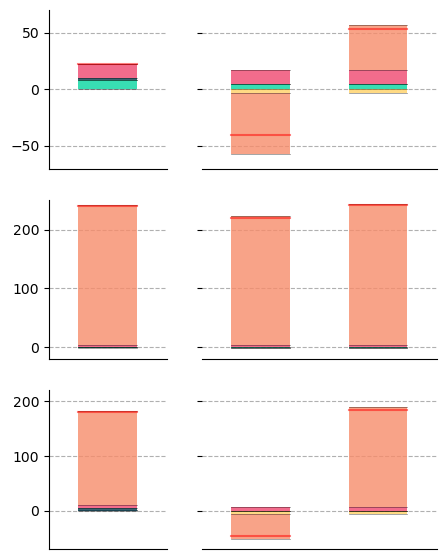

In [230]:


fig, axs = plt.subplots(3, 2, figsize=(5, 7), gridspec_kw={'width_ratios': [1, 2]})

bars_to_ax(
    axs[0,1],
    neg['zonal'],
    loads.loc[neg['zonal'].index],
    lw,
    sc.loc[idx[neg['zonal'].index, :], 'zonal'].unstack().drop(columns=['balancing_volume']),
    [low_cost_regions, high_cost_regions]
    )

bars_to_ax(
    axs[0,0],
    neg['national'],
    loads.loc[neg['national'].index],
    lw,
    sc.loc[idx[neg['national'].index, :], 'national'].unstack().drop(columns=['balancing_volume']),
    [['GB']]
    )

bars_to_ax(
    axs[1,1],
    pos['zonal'],
    loads.loc[pos['zonal'].index],
    lw,
    sc.loc[idx[pos['zonal'].index, :], 'zonal'].unstack().drop(columns=['balancing_volume']),
    [low_cost_regions, high_cost_regions]
    )

bars_to_ax(
    axs[1,0],
    pos['national'],
    loads.loc[pos['national'].index],
    lw,
    sc.loc[idx[pos['national'].index, :], 'national'].unstack().drop(columns=['balancing_volume']),
    [['GB']]
    )

bars_to_ax(
    axs[2,1],
    mixed['zonal'],
    loads.loc[mixed['zonal'].index],
    lw,
    sc.loc[idx[mixed['zonal'].index, :], 'zonal'].unstack().drop(columns=['balancing_volume']),
    [low_cost_regions, high_cost_regions]
    )

bars_to_ax(
    axs[2,0],
    mixed['national'],
    loads.loc[mixed['national'].index],
    lw,
    sc.loc[idx[mixed['national'].index, :], 'national'].unstack().drop(columns=['balancing_volume']),
    [['GB']]
    )

for ax in axs[:, 0]:
    ax.set_xlim(-0.5, 0.5)

for ax in axs[:, 1]:
    ax.set_xlim(-0.5, 1.5)

for ax in axs[:,1]:
    ax.set_yticklabels([])
    # (Intentionally left blank so as not to remove the y-ticks; the grid remains via the existing ticks.)
    ax.spines['left'].set_visible(False)


for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', axis='y')
    ax.set_axisbelow(True)

for ax in axs[0]:
    ax.set_ylim(-70, 70)
for ax in axs[1]:
    ax.set_ylim(-20, 250)
for ax in axs[2]:
    ax.set_ylim(-70, 220)

plt.show()

2022-01-01 00:00:00
 73.097151    225
-77.290000     59
Name: count, dtype: int64